In [1]:
from idu_clients import UrbanAPI, TransportFramesAPI

urban_api = UrbanAPI('http://10.32.1.107:5300')
ts_api = TransportFramesAPI("http://10.32.1.65:5700")

Получение регионов и выбранного региона

In [2]:
regions = await urban_api.get_regions()
region = regions[regions.index == 1]
region

,geometry,territory_type,parent_id,name,level,properties,admin_center,okato_code,oktmo_code,created_at,updated_at
territory_id,,,,,,,,,,,
1,"MULTIPOLYGON (((34.32572 59.19331, 34.32541 59...","{'territory_type_id': 1, 'name': 'Субъект Феде...",12639,Ленинградская область,2,"{'Малые города': 15, 'Крупные города': 0, 'Вуз...",None,41000000000,None,2024-06-16T21:35:40.801621Z,2024-06-16T21:35:40.801621Z


API : метод получения населенных пунктов и административных единиц

In [3]:
gdfs = await urban_api.get_region_territories(1)
towns_db = gdfs[5]
del gdfs[5]
adm_units = gdfs
adm_units[3].head()

,geometry,territory_type,parent_id,name,level,properties,admin_center,okato_code,oktmo_code,created_at,updated_at,territory_type_id,territory_type_name
territory_id,,,,,,,,,,,,,
2,"POLYGON ((34.32834 59.19564, 34.32777 59.19548...","{'territory_type_id': 2, 'name': 'Муниципально...",1,Бокситогорский муниципальный район,3,"{'Малые города': 2, 'Крупные города': 0, 'Числ...",NaN,41203000000,None,2024-06-16T21:35:40.801621Z,2024-06-16T21:35:40.801621Z,2,Муниципальное образование
10,"POLYGON ((28.98894 59.48069, 28.98604 59.48401...","{'territory_type_id': 2, 'name': 'Муниципально...",1,Волосовский муниципальный район,3,"{'Малые города': 0, 'Крупные города': 0, 'Числ...",NaN,41206000000,None,2024-06-16T21:35:40.801621Z,2024-06-16T21:35:40.801621Z,2,Муниципальное образование
18,"POLYGON ((32.85314 60.51175, 32.84899 60.50379...","{'territory_type_id': 2, 'name': 'Муниципально...",1,Волховский муниципальный район,3,"{'Малые города': 0, 'Крупные города': 0, 'Числ...",NaN,41209000000,None,2024-06-16T21:35:40.801621Z,2024-06-16T21:35:40.801621Z,2,Муниципальное образование
34,"MULTIPOLYGON (((30.55161 59.96981, 30.55200 59...","{'territory_type_id': 2, 'name': 'Муниципально...",1,Всеволожский муниципальный район,3,"{'Малые города': 1, 'Крупные города': 0, 'Числ...",NaN,41212000000,None,2024-06-16T21:35:40.801621Z,2024-06-16T21:35:40.801621Z,2,Муниципальное образование
54,"POLYGON ((28.99640 60.03638, 28.85880 60.04000...","{'territory_type_id': 2, 'name': 'Муниципально...",1,Выборгский муниципальный район,3,"{'Малые города': 0, 'Крупные города': 0, 'Числ...",NaN,41215000000,None,2024-06-16T21:35:40.801621Z,2024-06-16T21:35:40.801621Z,2,Муниципальное образование


API : метод получения типов сервисов региона

In [4]:
service_types = await urban_api.get_service_types()
service_types.head()

,urban_function_id,name,capacity_modeled,code
service_type_id,,,,
0,4,Водный объект,None,0
1,2,Парк,None,1
2,2,Лес,None,2
3,2,Заказник,None,3
4,2,Заповедник,None,4


API : Метод получения нормативов региона

In [5]:
normatives = await urban_api.get_territory_normatives(1)
normatives

""


API : метод получения матрицы интермодальной доступности

In [6]:
acc_mx = await ts_api.get_accessibility_matrix(1, 'intermodal')

Метод : Инициализация списка типов сервисов региона

In [7]:
import pandera as pa
import geopandas as gpd
from shapely import Point, MultiPoint, Polygon, MultiPolygon, LineString, MultiLineString
from pandera.typing import Series, Index
from pandera.typing.geopandas import GeoSeries


class BaseSchema(pa.DataFrameModel):
    idx: Index[int] = pa.Field(unique=True)
    geometry: GeoSeries
    _geom_types = [Point, MultiPoint, Polygon, MultiPolygon, LineString, MultiLineString]

    class Config:
        strict = "filter"
        add_missing_columns = True

    @classmethod
    def to_gdf(cls):
        columns = cls.to_schema().columns.keys()
        return gpd.GeoDataFrame(data=[], columns=columns, crs=4326)

    @pa.check("geometry")
    @classmethod
    def check_geometry(cls, series):
        return series.map(lambda x: any([isinstance(x, geom_type) for geom_type in cls._geom_types]))

In [8]:
import random

class ServiceTypesSchema(pa.DataFrameModel):
  idx : Index[int] = pa.Field(unique=True)
  name : Series[str]
  category : Series[str]
  weight : Series[float] = pa.Field(nullable=True, coerce=True)
  ...

service_types['category'] = service_types.apply(lambda _ : random.choice(['Базовая', 'Дополнительная', 'Комфорт']), axis=1)
service_types['weight'] = service_types.apply(lambda _ : random.choice([round(random.random(),2),None]), axis=1)
ServiceTypesSchema(service_types).head()

,urban_function_id,name,capacity_modeled,code,category,weight
service_type_id,,,,,,
0,4,Водный объект,None,0,Комфорт,0.78
1,2,Парк,None,1,Комфорт,NaN
2,2,Лес,None,2,Комфорт,NaN
3,2,Заказник,None,3,Базовая,NaN
4,2,Заповедник,None,4,Комфорт,0.24


In [9]:
class NormativesSchema(pa.DataFrameModel):
  service_type_id : Series[int]
  radius_availability_meters : Series[float] = pa.Field(coerce=True, nullable=True)
  time_availability_minutes : Series[float] = pa.Field(coerce=True, nullable=True)
  services_per_1000_normative : Series[float] = pa.Field(coerce=True, nullable=True)
  services_capacity_per_1000_normative : Series[float] = pa.Field(coerce=True, nullable=True)
  
  @pa.dataframe_check()
  @classmethod
  def check_availability(cls, df):
      return ~df['radius_availability_meters'].isna() ^ ~df['time_availability_minutes'].isna()
  
  @pa.dataframe_check()
  @classmethod
  def check_supply(cls, df):
      return ~df['services_per_1000_normative'].isna() ^ ~df['services_capacity_per_1000_normative'].isna()

import pandas as pd

service_types_ids = random.choices(service_types.index, k=len(service_types)//2)
normatives = []
for st_id in service_types_ids:
  normative = {
    'service_type_id': st_id,
  }
  if random.randint(0,1) == 1:
    normative['radius_availability_meters'] = random.randint(500,1000)
  else:
    normative['time_availability_minutes'] = random.randint(5,60)
  if random.randint(0,1) == 1:
    normative['services_per_1000_normative'] = random.randint(1,5)
  else:
    normative['services_capacity_per_1000_normative'] = random.randint(1,500)
  normatives.append(normative)
normatives = pd.DataFrame(normatives)
NormativesSchema(normatives).head()

,service_type_id,radius_availability_meters,services_capacity_per_1000_normative,time_availability_minutes,services_per_1000_normative
0,116,727.0,123.0,NaN,NaN
1,40,NaN,NaN,32.0,1.0
2,25,591.0,NaN,NaN,4.0
3,69,NaN,56.0,60.0,NaN
4,94,NaN,162.0,33.0,NaN


In [10]:
from pydantic import BaseModel, Field, field_validator
from enum import Enum
import numpy as np

class AccessibilityType(Enum):
  METERS = 'м'
  MINUTES = 'мин'

class SupplyType(Enum):
  SERVICES_PER_1000 = 'шт. на 1000 человек'
  CAPACITY_PER_1000 = 'ед. на 1000 человек'

class Category(Enum):
  BASIC = 'Базовая'
  ADDITIONAL = 'Дополнительная'
  COMFORT = "Комфорт"

class ServiceType(BaseModel):
  id : int
  accessibility_value : float = Field(ge=0)
  supply_value : float = Field(ge=0)
  accessibility_type : AccessibilityType
  supply_type : SupplyType
  category : Category
  weight : float = Field(coerce=True, nullable=True)

  @field_validator('weight', mode='after')
  @classmethod
  def validate_weight(cls, w):
    if not np.isnan(w):
      assert 0 <= w <= 1, ''
    return w 

  @classmethod
  def from_series(cls, series : pd.Series):
    i = series.name
    
    if not np.isnan(series['radius_availability_meters']):
      accessibility_type = AccessibilityType.METERS
      accessibility_value = series['radius_availability_meters']
    else:
      accessibility_type = AccessibilityType.MINUTES
      accessibility_value = series['time_availability_minutes']

    if not np.isnan(series['services_per_1000_normative']):
      supply_type = SupplyType.SERVICES_PER_1000
      supply_value = series['services_per_1000_normative']
    else:
      supply_type = SupplyType.CAPACITY_PER_1000
      supply_value = series['services_capacity_per_1000_normative']

    category = series['category']
    if category == 'Базовая':
      category = Category.BASIC
    elif category == 'Дополнительная':
      category = Category.ADDITIONAL
    else :
      category = Category.COMFORT

    return cls(
      id = i,
      accessibility_value = accessibility_value,
      accessibility_type = accessibility_type, 
      supply_value = supply_value,
      supply_type = supply_type,
      weight = series['weight'],
      category=category
    )

  @classmethod
  def initialize_service_types(cls, service_types : gpd.GeoDataFrame, normatives : gpd.GeoDataFrame) -> list :
    service_types = ServiceTypesSchema(service_types)
    normatives = NormativesSchema(normatives)
    service_types = service_types.merge(normatives, left_index=True, right_on='service_type_id')
    return [cls.from_series(s) for _, s in service_types.iterrows()]

service_types = {st.id : st for st in ServiceType.initialize_service_types(service_types, normatives)}

In [11]:
import pandas as pd
import geopandas as gpd

towns = gpd.read_file('towns.geojson')[['geometry', 'rounded_population']].rename(columns={'rounded_population':'population'})
towns.population = towns.population.apply(int)

towns.head()

,geometry,population
0,"POLYGON ((33.79410 59.36206, 33.79334 59.35856...",10
1,"POLYGON ((33.82129 59.47496, 33.82053 59.47146...",68
2,"POLYGON ((33.82765 59.47334, 33.82689 59.46985...",1734
3,"POLYGON ((33.81098 59.44228, 33.81022 59.43878...",10
4,"POLYGON ((33.71243 59.32801, 33.71168 59.32451...",10


## Код

In [12]:
sts = filter(lambda st : st.supply_type == SupplyType.CAPACITY_PER_1000 and st.accessibility_type == AccessibilityType.MINUTES, service_types.values())
service_type = list(sts)[0]
service_type

ServiceType(id=71, accessibility_value=40.0, supply_value=151.0, accessibility_type=<AccessibilityType.MINUTES: 'мин'>, supply_type=<SupplyType.CAPACITY_PER_1000: 'ед. на 1000 человек'>, category=<Category.BASIC: 'Базовая'>, weight=0.11)

In [13]:
class SuppliesSchema(pa.DataFrameModel):
  idx : Index[int] = pa.Field(unique=True)
  supply : Series[float] = pa.Field(coerce = True)
  # delta : Series[float] = pa.Field(coerce = True, nullable=True)

  # class Config:
  #   add_missing_columns = True

supplies = []
for i in towns.index:
  supplies.append({
    'id' : i,
    'supply' : random.randint(0,100)
  })
supplies_df = pd.DataFrame(supplies).set_index('id', drop=True)
SuppliesSchema(supplies_df).head()

,supply
id,
0,63.0
1,8.0
2,66.0
3,32.0
4,97.0


In [14]:
from shapely import Point

class TownsSchema(BaseSchema):
  idx : Index[int] = pa.Field(unique=True)
  population : Series[int] = pa.Field(coerce = True)
  _geom_types = [Point]
  # delta : Series[float] = pa.Field(coerce = True, nullable=True)

  @pa.parser('geometry')
  @classmethod
  def parse_geometry(cls, series):
    name = series.name
    return series.representative_point().rename(name)

  # class Config:
  #   add_missing_columns = True

TownsSchema(towns).head()

,geometry,population
0,POINT (33.75892 59.36226),10
1,POINT (33.78600 59.47517),68
2,POINT (33.79236 59.47356),1734
3,POINT (33.77572 59.44249),10
4,POINT (33.67728 59.32819),10


In [15]:
from loguru import logger
import geopandas as gpd
import pandas as pd
from pulp import PULP_CBC_CMD, LpMaximize, LpProblem, LpVariable, lpSum, LpInteger

POPULATION_COLUMN = 'population'
SUPPLY_COLUMN = 'supply'

CAPACITY_COLUMN = 'capacity'
CAPACITY_LEFT_COLUMN = 'capacity_left'
DEMAND_COLUMN = 'demand'
DEMAND_LEFT_COLUMN = 'demand_left'
DEMAND_WITHIN_COLUMN = 'demand_within'
DEMAND_WITHOUT_COLUMN = 'demand_without'
PROVISION_COLUMN = "provision"

class ProvisionModel():

    def __init__(self, towns_gdf : gpd.GeoDataFrame, acc_mx : pd.DataFrame, max_depth : int = 5, verbose : bool = True):
        assert (towns_gdf.index == acc_mx.index).all(), 'Towns index and acc_mx index should match'
        assert (towns_gdf.index == acc_mx.columns).all(), 'Towns index and acc_mx columns should match'
        self.towns_gdf = TownsSchema(towns_gdf)
        self.accessibility_matrix = acc_mx.copy()
        self.max_depth = max_depth
        self.verbose = verbose

    def _preprocess_gdf(self, supplies_df : SuppliesSchema, service_type : ServiceType):
        gdf = self.towns_gdf.copy()
        gdf[DEMAND_COLUMN] = gdf[POPULATION_COLUMN].apply(lambda p : round(p/1000*service_type.supply_value))
        gdf[CAPACITY_COLUMN] = supplies_df[SUPPLY_COLUMN]
        gdf[CAPACITY_LEFT_COLUMN] = gdf[CAPACITY_COLUMN]
        gdf[DEMAND_LEFT_COLUMN] = gdf[DEMAND_COLUMN]
        gdf[DEMAND_WITHIN_COLUMN] = 0
        gdf[DEMAND_WITHOUT_COLUMN] = 0
        return gdf
    
    @classmethod
    def total(cls, gdf: gpd.GeoDataFrame) -> float:
        return gdf[DEMAND_WITHIN_COLUMN].sum() / gdf[DEMAND_COLUMN].sum()
    
    @staticmethod
    def agregate(towns : gpd.GeoDataFrame, units : gpd.GeoDataFrame):
        units = units[['geometry']].copy()
        sjoin = units.sjoin(towns, how='left')
        sjoin = sjoin.reset_index()
        sjoin = sjoin.groupby('territory_id').agg({
            CAPACITY_COLUMN : 'sum',
            CAPACITY_LEFT_COLUMN : 'sum',
            DEMAND_COLUMN : 'sum',
            DEMAND_LEFT_COLUMN : 'sum',
            DEMAND_WITHIN_COLUMN : 'sum',
            DEMAND_WITHOUT_COLUMN : 'sum'
        })
        sjoin[PROVISION_COLUMN] = sjoin[DEMAND_WITHIN_COLUMN] / sjoin[DEMAND_COLUMN]
        return units.merge(sjoin, left_index=True, right_index=True)

    def calculate(
        self, supplies_df : pd.DataFrame, service_type: ServiceType, self_supply: bool = True,
    ) -> gpd.GeoDataFrame:
        
        gdf = self._preprocess_gdf(supplies_df, service_type)

        if self_supply:
            supply : pd.Series = gdf.apply(lambda x: min(x[DEMAND_COLUMN], x[CAPACITY_COLUMN]), axis=1)
            gdf[DEMAND_WITHIN_COLUMN] += supply
            gdf[DEMAND_LEFT_COLUMN] -= supply
            gdf[CAPACITY_LEFT_COLUMN] -= supply

        gdf = self._lp_provision(gdf, service_type)

        gdf[PROVISION_COLUMN] = gdf[DEMAND_WITHIN_COLUMN] / gdf[DEMAND_COLUMN]

        if self.verbose:
            logger.success("Provision assessment finished")

        return gdf

    def _lp_provision(
        self,
        gdf: gpd.GeoDataFrame,
        service_type: ServiceType,
        depth: int = 1,
    ) -> gpd.GeoDataFrame:
        
        selection_range = depth * service_type.accessibility_value

        def _get_distance(id1: int, id2: int):
            distance = self.accessibility_matrix.loc[id1, id2]
            return distance if distance > 1 else 1

        def _get_weight(id1: int, id2: int):
            distance = _get_distance(id1, id2)
            return 1 / (distance * distance)

        demand = gdf.loc[gdf[DEMAND_LEFT_COLUMN] > 0]
        capacity = gdf.loc[gdf[CAPACITY_LEFT_COLUMN] > 0]

        if self.verbose:
            logger.info(f"Setting an LP problem for depth = {depth} : {len(demand)}x{len(capacity)}")

        prob = LpProblem("Provision", LpMaximize)
        # Precompute distance and filter products
        products = [
            (i, j)
            for i in demand.index
            for j in capacity.index
            if _get_distance(i, j) <= selection_range  # service_type.accessibility * 2
        ]

        # Create the decision variable dictionary
        x = LpVariable.dicts("Route", products, 0, None, cat=LpInteger)

        # Objective Function
        prob += lpSum(_get_weight(n, m) * x[n, m] for n, m in products)

        # Constraint dictionaries
        demand_constraints = {n: [] for n in demand.index}
        capacity_constraints = {m: [] for m in capacity.index}

        for n, m in products:
            demand_constraints[n].append(x[n, m])
            capacity_constraints[m].append(x[n, m])

        # Add Demand Constraints
        for n in demand.index:
            prob += lpSum(demand_constraints[n]) <= demand.loc[n, DEMAND_LEFT_COLUMN]

        # Add Capacity Constraints
        for m in capacity.index:
            prob += lpSum(capacity_constraints[m]) <= capacity.loc[m, CAPACITY_LEFT_COLUMN]

        # if self.verbose:
        #     logger.info("Solving the problem")
        prob.solve(PULP_CBC_CMD(msg=False))

        # if self.verbose:
        #     logger.info("Restoring values from variables")

        for var in prob.variables():
            value = var.value()
            name = var.name.replace("(", "").replace(")", "").replace(",", "").split("_")
            if name[2] == "dummy":
                continue
            a = int(name[1])
            b = int(name[2])
            distance = _get_distance(a, b)
            if value > 0:
                if distance <= service_type.accessibility_value:
                    gdf.loc[a, DEMAND_WITHIN_COLUMN] += value
                else:
                    gdf.loc[a, DEMAND_WITHOUT_COLUMN] += value
                gdf.loc[a, DEMAND_LEFT_COLUMN] -= value
                gdf.loc[b, CAPACITY_LEFT_COLUMN] -= value

        if gdf[DEMAND_LEFT_COLUMN].sum() > 0 and gdf[CAPACITY_LEFT_COLUMN].sum() > 0 and depth < self.max_depth:
            return self._lp_provision(gdf, service_type, depth + 1)
        return gdf

In [17]:
towns.index = acc_mx.index
prov_model = ProvisionModel(towns, acc_mx)

In [18]:
res = prov_model.calculate(supplies_df, service_type)

2024-10-11 16:05:56.843 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 1 : 526x2170


2024-10-11 16:06:09.993 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 2 : 198x532
2024-10-11 16:06:10.839 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 3 : 187x272
2024-10-11 16:06:11.481 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 4 : 156x133
2024-10-11 16:06:11.664 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 5 : 156x115
2024-10-11 16:06:11.864 | SUCCESS  | __main__:calculate:74 - Provision assessment finished


<Axes: >

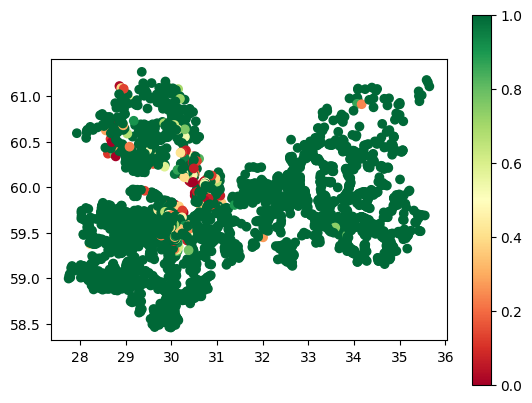

In [19]:
res.plot(column='provision', cmap='RdYlGn', vmax=1, vmin=0, legend=True)

## Метод агрегации

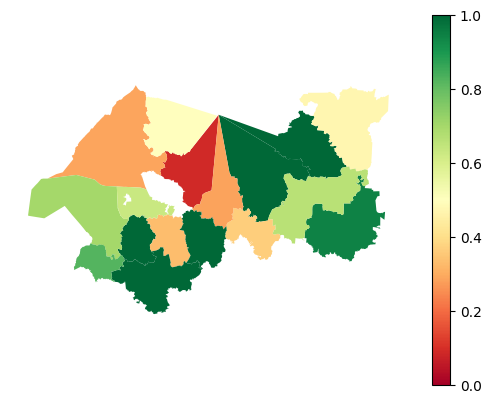

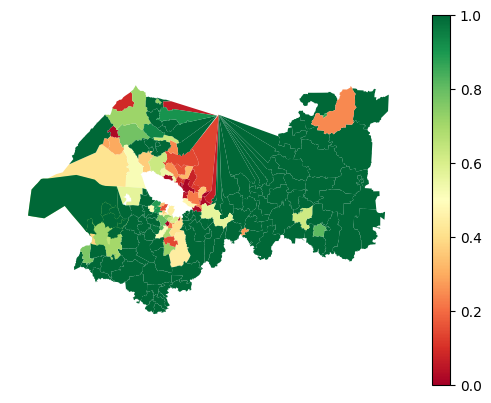

In [20]:
for level, gdf in gdfs.items():
  agg = ProvisionModel.agregate(res, gdf)
  agg.plot(column='provision', cmap='RdYlGn', vmax=1, vmin=0, legend=True).set_axis_off()


## TerritoryAssessment

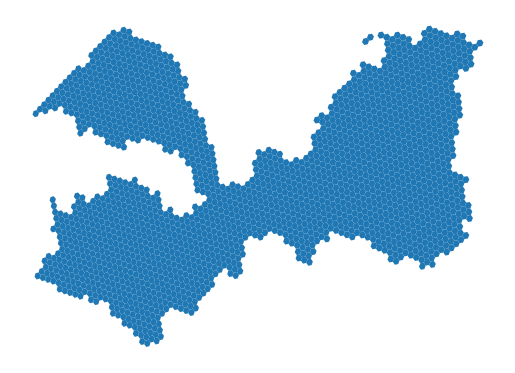

In [21]:
grid = gpd.read_file('grid.geojson')
grid.plot().set_axis_off()

In [22]:
sts = filter(lambda st : st.supply_type == SupplyType.CAPACITY_PER_1000 and st.accessibility_type == AccessibilityType.MINUTES, service_types.values())
provisions = {st.id : prov_model.calculate(supplies_df, st) for st in sts}

2024-10-11 16:06:13.493 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 1 : 526x2170
2024-10-11 16:06:26.360 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 2 : 198x532
2024-10-11 16:06:27.253 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 3 : 187x272
2024-10-11 16:06:28.014 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 4 : 156x133
2024-10-11 16:06:28.199 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 5 : 156x115
2024-10-11 16:06:28.436 | SUCCESS  | __main__:calculate:74 - Provision assessment finished
2024-10-11 16:06:28.459 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 1 : 799x1901
2024-10-11 16:06:47.003 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 2 : 453x214
2024-10-11 16:06:47.779 | INFO     | __main__:_lp_provision:99 - Setting an LP problem for depth = 3 : 453x7
2024-10-11 16:06:47.8

In [23]:
filter(lambda st : st.supply_type == SupplyType.CAPACITY_PER_1000 and st.accessibility_type == AccessibilityType.MINUTES, service_types.values())

[]